# Finding top topics in a Stack Overflow post using TF-IDF

___

The aim of this personal project is to practice what I have learned during the *Machine Learning Fundamentals* classroom course by [Telecom academy](https://www.telacad.ro/cursuri/machine-learning-fundamentals/). 

The objective of the task is to find top 3 topics in a Stack Overflow post. The dataset consistits of 13500 Stack Overflow posts collected from a [BigQuery dataset](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow?filter=solution-type:dataset&q=stack%20overflow&id=46a148ff-896d-444c-b08d-360169911f59) which includes an archive of Stack Overflow content, including posts, votes, tags, and badges.

In the current dataset, posts from 2008 to 2016 with a score greater than 10 were selected, 1500 for each year. Every row in this dataset has 5 columns:

* *title* of post, can be null
* *body* of post, in html format
* *tags*, can be null
* *score*, number of thumbs ups
* *year* it was posted

In [2]:
import pandas as pd

data = pd.read_csv('data.csv')

In [3]:
data.head()

,title,body,tags,score,year
0,How do I detach objects in Entity Framework Co...,<p>There is no <code>Detach(object entity)</co...,entity-framework entity-framework-4.1 ef-code-...,70,2011
1,Oracle PL/SQL - How to create a simple array v...,<p>I'd like to create an in-memory array varia...,oracle plsql oracle9i,63,2011
2,What is the origin and purpose of the variable...,<p>In the <a href= http://learn.knockoutjs.com...,javascript html knockout.js,62,2011
3,What's the fundamental difference between MFC ...,<p><em>Assuming I am <strong>only</strong> usi...,c++ visual-c++ mfc atl,63,2011
4,Scala: What is the difference between Traversa...,<p>I have looked at <a href= http://stackoverf...,scala scala-collections,63,2011


### Text preprocessing

We will consider a post is composed by *title* and *body*. First we will focus on the *body*, converting its html format to text. For this we will use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), which is a python library for pulling data out of html or xml files. 

In [6]:
from bs4 import BeautifulSoup

bodies = [BeautifulSoup(x).get_text() for x in data['body']]
bodies[0]

'There is no Detach(object entity) on the DbContext. Do I have the ability to detach objects on EF code first?'

Now let's put together bodies and titles to obtain the posts.

In [7]:
posts = [str(data['title'].iloc[i]) + ' ' + bodies[i] for i in range(13500)]

Text will be cleaned in two steps. 

First, unnecessary blank spaces as well as break lines and tabs will be removed from text. Lowercase is also being applied and most common abbreviations are replaced.

In [8]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\t", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [9]:
posts = [clean_text(post) for post in posts]

Second step is to remove punctuation, but we want to keep tokens like *c++*, *c#* or *asp.net* since those could represent a topic in a post. 

In order to do this, we will create a list of tokens we want to keep using information from *tags* column:

In [10]:
all_tags = [str(tags).split() for tags in data['tags']]

So far we got a list of lists. Let's transform it into a list of unique tags:

In [11]:
all_tags = list(set([tag for tags in all_tags for tag in tags]))
all_tags[:10]

['underline',
 'one-to-many',
 'launch',
 'graph-algorithm',
 'git-push',
 'serverside-javascript',
 'arithmeticexception',
 'v8',
 'swing',
 'codedom']

For tokenization, we'll use the nltk tok-tok tokenizer which is a simple, general tokenizer. 

This simple tokenizer will also generate tokens with punctuation, as we need.

In [12]:
from nltk.tokenize import ToktokTokenizer

tokenizer = ToktokTokenizer()
posts_tokens = [tokenizer.tokenize(post) for post in posts]

Now punctuation together with links, blank spaces and digits will be removed from the generated tokens, but only if the tokens are not in the *all_tags* list we created in the previous step.

In [13]:
import re

def clean_tokens(post_tokens):
    new_tokens = []
    for token in post_tokens:
        if token not in all_tags:
            token = re.sub(r"http\S+", '', token) #remove links
            token = re.sub(r'[^a-zA-Z0-9\s]', '', token)
            token = re.sub('\d+', '', token)
            token = re.sub(' +', ' ', token)
            if token != '':
                new_tokens.append(token)
        else:
            new_tokens.append(token)
    return new_tokens

In [14]:
posts_tokens = [clean_tokens(post) for post in posts_tokens]

There are lots of words written together, mostly from variables. Those will be splitted using [wordninja](https://github.com/keredson/wordninja).

In [15]:
import wordninja

def word_ninja(post_tokens):
    split_ninja = []
    for token in post_tokens:
        if token not in all_tags:
            for word in wordninja.split(token):
                split_ninja.append(word)
        else:
            split_ninja.append(token)
    return split_ninja

posts_tokens = [word_ninja(post_tokens) for post_tokens in posts_tokens]

Last step of our preprocessing will be lemmatization:

In [16]:
from nltk.stem.wordnet import WordNetLemmatizer

lm = WordNetLemmatizer()

def lemmatize(post_tokens):
    lemm_words = [lm.lemmatize(w) for w in post_tokens]
    return lemm_words

posts_tokens = [lemmatize(post_tokens) for post_tokens in posts_tokens]

Joining the tokens together to obtain the processed posts:

In [23]:
posts = [' '.join(post) for post in posts_tokens]
posts[:2]

['how do i detach object in entity framework code first there is no detach object entity on the dbcontext do i have the ability to detach object on ef code first',
 'oracle plsql how to create a simple array variable i would like to create an in memory array variable that can be used in my plsql code i can not find any collection in oracle plsql that us pure memory they all seem to be associated with table i am looking to do something like this in my plsql c# syntax string array value new string matt joanne robert edit oracle i']

### Topic Extraction

For extracting the top 3 topics from each of our preprocessed posts we will use tf-idf representation of documents (posts):

$$tfidf_{i,d} = tf_{i,d} \cdot idf_{i}$$

where term frequency is

 $$ tf_{i,d} = \frac{n_{i,d}}{\sum_k n_{k,d}} $$

and inverse document frequency (total number of documents divided by number of documents containing the term - log scaled) is

$$ idf_i = \mbox{log} \frac{|D|}{|{d : t_i \in d}|} $$

Terms with the highest tf-idf scores are the terms in a document that are distinctively frequent in a document. Therefore this approach is suitable for our task.

In the sklearn representation we'll use, we we''ll ignore all words that have appeared in 85% of the documents, since those may be unimportant. Token pattern is also defined so words with punctuation (ex: c#) will be included in the vocabulary.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vect = TfidfVectorizer(analyzer = 'word', token_pattern=r"(?u)\S\S+", max_df = 0.85)

tf = tf_vect.fit(posts)

Now our aim is to transform each post in a tf-idf sparse vector. We are interested in the features with the highest score, so we will order descending scores(together with indexes so we can indentify the features) in a vector. For example:

In [25]:
doc = posts[0]

tf_idf_vector = tf_vect.transform([doc]).tocoo()

tuples = zip(tf_idf_vector.col, tf_idf_vector.data)
print(sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True))

[(4384, 0.7366998786464907), (5510, 0.32874061202934046), (11648, 0.2822794991788995), (4018, 0.24556662621549688), (5171, 0.19672337570534731), (6286, 0.19534906162524193), (49, 0.1788028093709509), (2932, 0.15192581477114478), (6577, 0.14177114935091592), (4796, 0.12328330898258376), (11823, 0.12194875338894641), (11386, 0.08661550416397751), (7790, 0.07682872867739814), (17109, 0.07260811549889164), (7458, 0.05853920346317664), (8182, 0.04279559635970894), (8770, 0.04229031560005689), (17302, 0.037577037018377175)]


In order to apply this, functions below are defined.

Sparse vector sorting:

In [26]:
def sort_tfidf_coo(tf_idf_vector):
    
    tuples = zip(tf_idf_vector.col, tf_idf_vector.data)
    
    return sorted(tuples, key=lambda x: x[1], reverse=True)

Top n topics (features corresponding to indexes) from sorted vector:

In [27]:
def extract_topn_from_vector(feature_names, sorted_items, topn):
    
    sorted_items = sorted_items[:topn]
    
    feature_vals = []
    for idx, _ in sorted_items:
        feature_vals.append(feature_names[idx])
    
    return feature_vals

Applying the functions and adding a new column in the dataframe with top 3 topics for each post:

In [28]:
feature_names = tf_vect.get_feature_names()

topics = []

for i in range(13500):
    
    doc = posts[i]
    tf_idf_vector = tf_vect.transform([doc])
    sorted_items=sort_tfidf_coo(tf_idf_vector.tocoo())
    
    keywords=extract_topn_from_vector(feature_names,sorted_items,3)

    top_topics = str()
    for k in keywords:
        top_topics = top_topics + str(k) + ' '
        
    topics.append(top_topics)

data['topics'] = topics

### Analytics based on our results

A sample of our dataframe together with results:

In [29]:
data.head(15)

,title,body,tags,score,year,topics
0,How do I detach objects in Entity Framework Co...,<p>There is no <code>Detach(object entity)</co...,entity-framework entity-framework-4.1 ef-code-...,70,2011,detach entity object
1,Oracle PL/SQL - How to create a simple array v...,<p>I'd like to create an in-memory array varia...,oracle plsql oracle9i,63,2011,plsql oracle array
2,What is the origin and purpose of the variable...,<p>In the <a href= http://learn.knockoutjs.com...,javascript html knockout.js,62,2011,folder data model
3,What's the fundamental difference between MFC ...,<p><em>Assuming I am <strong>only</strong> usi...,c++ visual-c++ mfc atl,63,2011,mfc atl tend
4,Scala: What is the difference between Traversa...,<p>I have looked at <a href= http://stackoverf...,scala scala-collections,63,2011,travers able trait
5,MySQL: Quick breakdown of the types of joins,<p>I would like a quick breakdown of the types...,mysql join,81,2011,join breakdown eid
6,Do I need 14 different layouts to support all ...,<p>I'm really feeling confused. From the <a hr...,android screen resolution android-screen-support,58,2011,layout vga dpi
7,Backbone.js fetch with parameters,<p>Following the <a href= http://documentcloud...,javascript backbone.js,132,2011,fetch item collection
8,How do I update a Tomcat webapp without restar...,<p>I'm new to <code>Tomcat</code>. We have a d...,tomcat deployment war,46,2011,tomcat dev apps
9,List all environment variables from command line?,<p>I'd like to know if it's possible from wind...,windows command-line environment-variables prompt,458,2011,en environment gci


Top topics for each year:

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def top_topics(year):

    topics_year = []

    for post_topics in data[data['year'] == year]['topics']:
        topics = post_topics.split(' ')
        for topic in topics:
            if topic != '':
                topics_year.append(topic)
    
    top_year = ' '.join(topics_year)

    plt.figure(figsize=(16, 8))

    cloud = WordCloud(width=400, height=400, background_color='white').generate(top_year)
    plt.subplot(122)
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(year, size=20)
    plt.show()

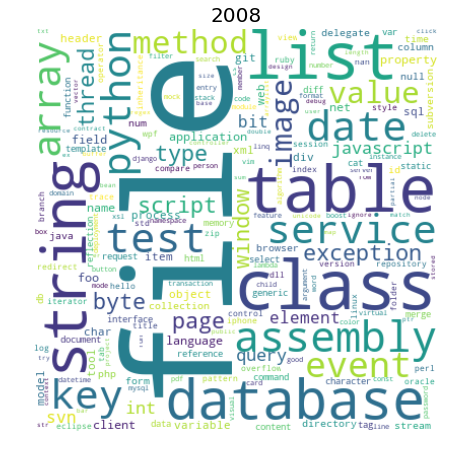

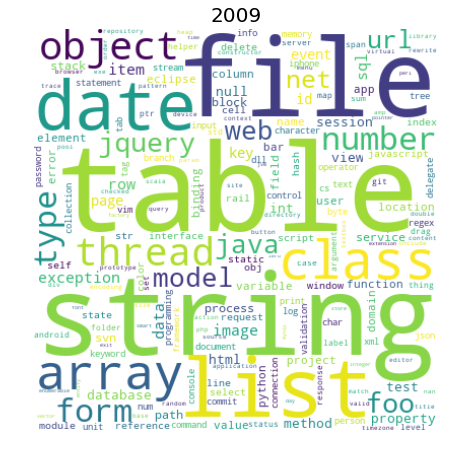

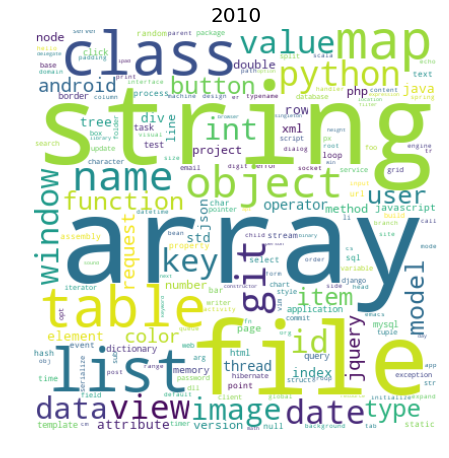

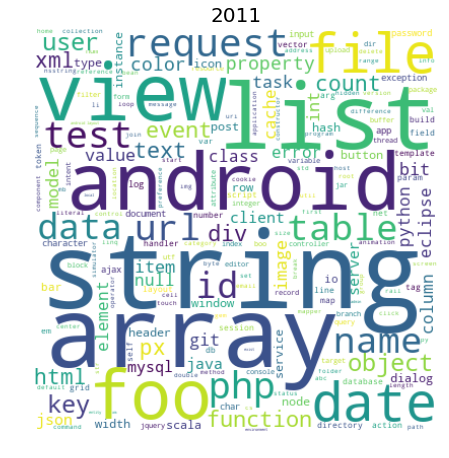

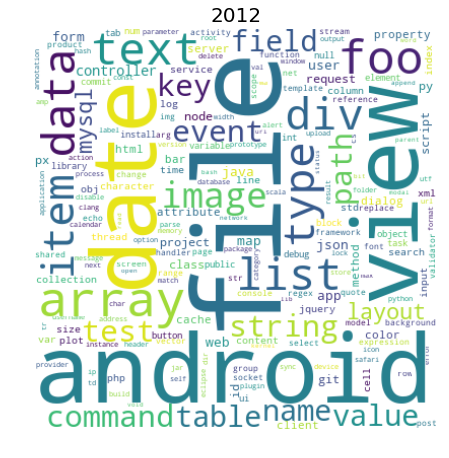

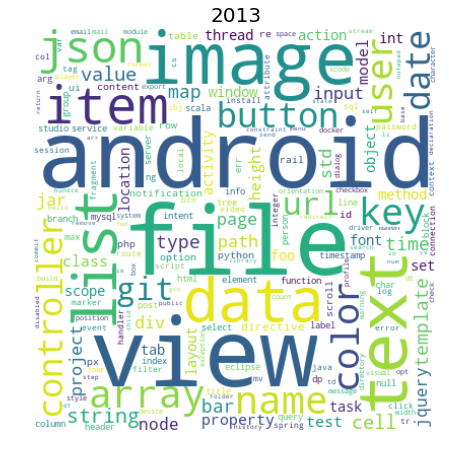

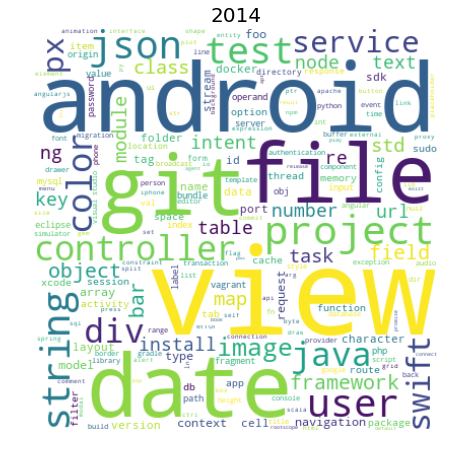

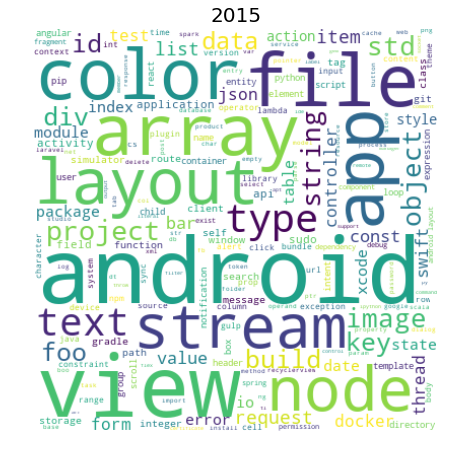

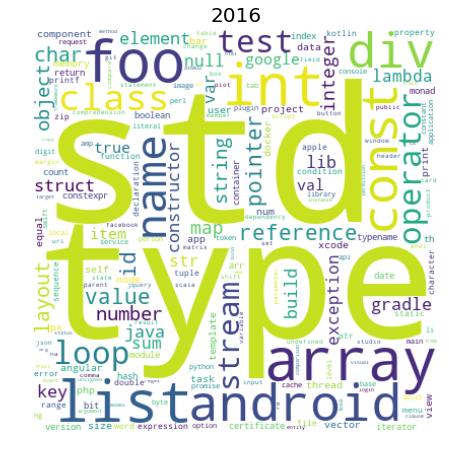

In [31]:
for year in range(2008, 2017):
    top_topics(year)

To conclude, the results can look a little bit dissappointing, but those are satisfactory considering our very simple approach.